<a href="https://colab.research.google.com/github/DinukiFernando/Facial-Emotion-Recognition-using-CNN/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


In [ ]:
pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 38.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
!pip install pytorch-lightning

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

Mounting Google Drive to access the dataset stored in the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Specify the directory where the dataset is located

In [ ]:
dir0 = '/content/drive/MyDrive/FER Dataset/dataset'

Loading Image Paths and Classes: Collect all image paths and their corresponding classes

In [ ]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg') :
            classes+=[dirname.split('/')[-1]]
            paths+=[(os.path.join(dirname, filename))]
print(len(paths))

12659


DataFrame Creation: Organize image paths and labels into a DataFrame for easier manipulation

In [ ]:
N=list(range(len(classes)))
class_names=sorted(set(classes))
print(class_names)
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
m=len(data)
M=list(range(m))
random.shuffle(M)
data=data.iloc[M]

['Angry', 'Happy', 'Neutral', 'Sad']


Data Transformation and Splitting: Apply necessary transformations like resizing, normalization, and data augmentation (horizontal flip) to the images.

In [ ]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

defines a function create_path_label_list that takes a DataFrame and creates a list of tuples, where each tuple contains a file path and its corresponding label. It then shuffles this list randomly and prints the length of the list and the first three elements.

In [ ]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,len(path_label))
print(len(path_label))
print(path_label[0:3])

12659
[('/content/drive/MyDrive/FER Dataset/dataset/Happy/cropped_emotions.418454.png', 1), ('/content/drive/MyDrive/FER Dataset/dataset/Neutral/00caae5bdffe04803a85d84d58ebaff96c0792cb5a178cfcf2c9b8e2f.jpg', 2), ('/content/drive/MyDrive/FER Dataset/dataset/Happy/0c4263f22ba2b73e50a3581b0a71ce71331781e835f7fc18a6a49054.jpg', 1)]


defines a custom dataset class CustomDataset that inherits from torch.utils.data.Dataset. This class is designed to handle the loading and preprocessing of image data for a neural network.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [ ]:
class ImageDataset(pl.LightningDataModule):
    def __init__(self, path_label, batch_size=32):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize(224),             # resize shortest side to 224 pixels
            transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        dataset_size = len(dataset)
        train_size = int(0.6 * dataset_size)
        val_size = dataset_size - train_size
        print(train_size,val_size)

        self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
        self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))
    def __len__(self):
        if self.train_dataset is not None:
            return len(self.train_dataset)
        elif self.val_dataset is not None:
            return len(self.val_dataset)
        else:
            return 0
    def __getitem__(self, index):
        if self.train_dataset is not None:
            return self.train_dataset[index]
        elif self.test_dataset is not None:
            return self.test_dataset[index]
        else:
            raise IndexError("Index out of range. The dataset is empty.")

    def train_dataset(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataset(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform=transform, batch_size=16):
        super().__init__()
        self.root_dir = dir0
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        data_set = datasets.ImageFolder(root=self.root_dir, transform=self.transform)

        n_data = len(dataset)
        n_train = int(0.6 * n_data)
        n_val = n_data - n_train
        train_dataset, val_dataset =  random_split(dataset, [n_train, n_val])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset

    def test_dataloader(self):
        return self.test_dataset

In [ ]:
class ConvolutionalNetwork(LightningModule):

    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [ ]:
dataset = ImageDataset(path_label)
dataset.setup()
train_dataloader = dataset.train_dataloader
val_dataloader = dataset.val_dataloader
#test_dataloader = dataset.test_dataloader
datamodule = DataModule()
model = ConvolutionalNetwork()

7595 5064


In [ ]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule)
val_loader = datamodule.val_dataloader()
trainer.test(dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 84    
---------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.447    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=9-step=2850.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=9-step=2850.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5352205634117126     │
│         test_loss         │     4.073408603668213     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.073408603668213, 'test_acc': 0.5352205634117126}]

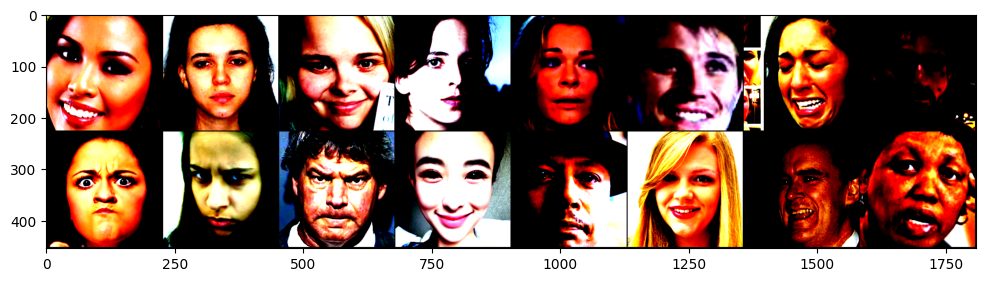

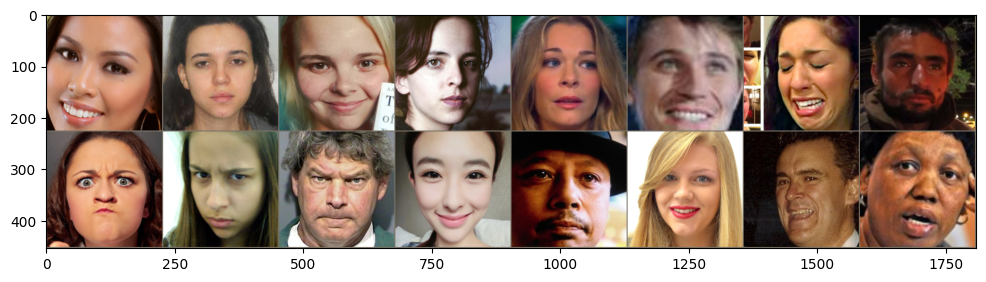

In [ ]:
for images, labels in datamodule.val_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

       Angry     0.8116    0.7296    0.7684       307
       Happy     0.8873    0.8414    0.8637       889
     Neutral     0.7403    0.8341    0.7844       916
         Sad     0.8027    0.7689    0.7854       926

    accuracy                         0.8058      3038
   macro avg     0.8105    0.7935    0.8005      3038
weighted avg     0.8095    0.8058    0.8063      3038



In [ ]:
import torch
from sklearn.metrics import classification_report

# Define the device
device = torch.device("cpu")  # or "cuda:0" if using GPU

# Define the satisfaction mapping function
def classify_emotion_to_satisfaction(emotion_label):
    if emotion_label == 1:  # Assuming 1 is Happy
        return 'Satisfied'
    elif emotion_label in [0, 3]:  # Assuming 0 is Angry, 3 is Sad
        return 'Unsatisfied'
    elif emotion_label == 2:  # Assuming 2 is Neutral
        return 'Neutral'
    else:
        return 'Unknown'

# Evaluate the model and classify emotions into satisfaction levels
model.eval()
y_true = []
y_pred = []
y_satisfaction_true = []
y_satisfaction_pred = []

with torch.no_grad():
    for test_data in datamodule.val_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)

        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

            # Add satisfaction classification
            y_satisfaction_true.append(classify_emotion_to_satisfaction(test_labels[i].item()))
            y_satisfaction_pred.append(classify_emotion_to_satisfaction(pred[i].item()))

# Print the classification report for emotions
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Print the classification report for satisfaction levels
satisfaction_class_names = ['Satisfied', 'Unsatisfied', 'Neutral']
print(classification_report(y_satisfaction_true, y_satisfaction_pred, target_names=satisfaction_class_names, digits=4))


              precision    recall  f1-score   support

       Angry     0.8116    0.7296    0.7684       307
       Happy     0.8873    0.8414    0.8637       889
     Neutral     0.7403    0.8341    0.7844       916
         Sad     0.8027    0.7689    0.7854       926

    accuracy                         0.8058      3038
   macro avg     0.8105    0.7935    0.8005      3038
weighted avg     0.8095    0.8058    0.8063      3038

              precision    recall  f1-score   support

   Satisfied     0.7403    0.8341    0.7844       916
 Unsatisfied     0.8873    0.8414    0.8637       889
     Neutral     0.8401    0.7924    0.8155      1233

    accuracy                         0.8193      3038
   macro avg     0.8226    0.8226    0.8212      3038
weighted avg     0.8238    0.8193    0.8202      3038

